<a href="https://colab.research.google.com/github/Volks44/VITMMA19/blob/main/Milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [3]:
import keras
from keras.datasets import cifar10
!pip install np_utils --quiet
import np_utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Visualize the first Training Images

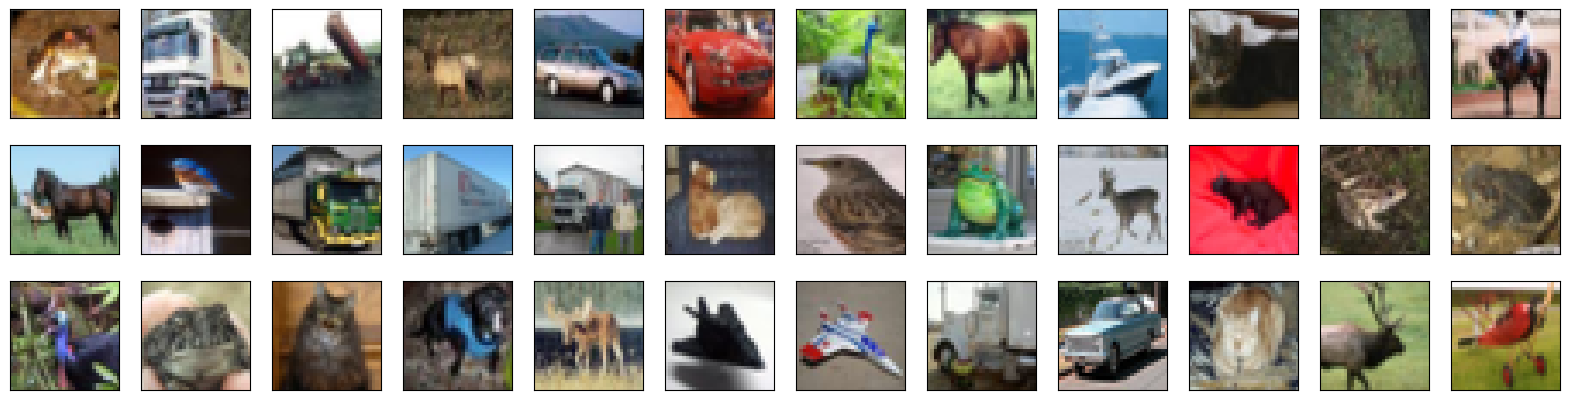

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

Image preprocesing

In [5]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Split dataset and one-hot encoding

In [6]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


Define the model

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# number of hidden units variable
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4

model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer.
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                       

data augmentation

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

Train the model

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# training
batch_size = 64
epochs=100

checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5', verbose=1, save_best_only=True)

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.56903, saving model to model.100epochs.hdf5
703/703 - 44s - loss: 2.7157 - accuracy: 0.2846 - val_loss: 1.5690 - val_accuracy: 0.4526 - 44s/epoch - 63ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100

Epoch 2: val_loss did not improve from 1.56903
703/703 - 30s - loss: 2.0073 - accuracy: 0.3772 - val_loss: 1.6020 - val_accuracy: 0.4485 - 30s/epoch - 42ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.56903 to 1.52951, saving model to model.100epochs.hdf5
703/703 - 30s - loss: 1.7682 - accuracy: 0.4278 - val_loss: 1.5295 - val_accuracy: 0.4882 - 30s/epoch - 43ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.52951
703/703 - 30s - loss: 1.6307 - accuracy: 0.4646 - val_loss: 1.5363 - val_accuracy: 0.4924 - 30s/epoch - 42ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.52951
703/703 - 29s - loss: 1.4990 - accuracy: 0.4985 - val_loss: 1.6646 - val_accuracy: 0.4774 - 29s/epoch - 42ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.52951 to 1.38563, saving model to model.100epochs.hdf5
703/703 - 30s - loss: 1.4070 - accuracy: 0.5307 - val_loss: 1.3856 - val_accuracy: 0.5391 - 30s/epoch - 43ms/step
Epoch 7/100

Epoch 7: val_loss improved from 1

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.100epochs.hdf5')

In [11]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 6ms/step - loss: 0.4889 - accuracy: 0.8561

Test result: 85.610 loss: 0.489


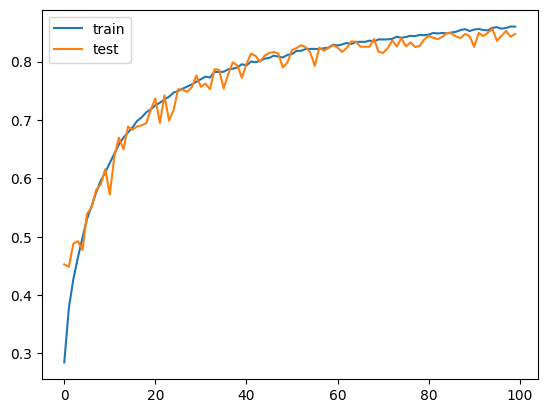

In [12]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
# get  on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

313/313 [==============================] - 2s 4ms/step


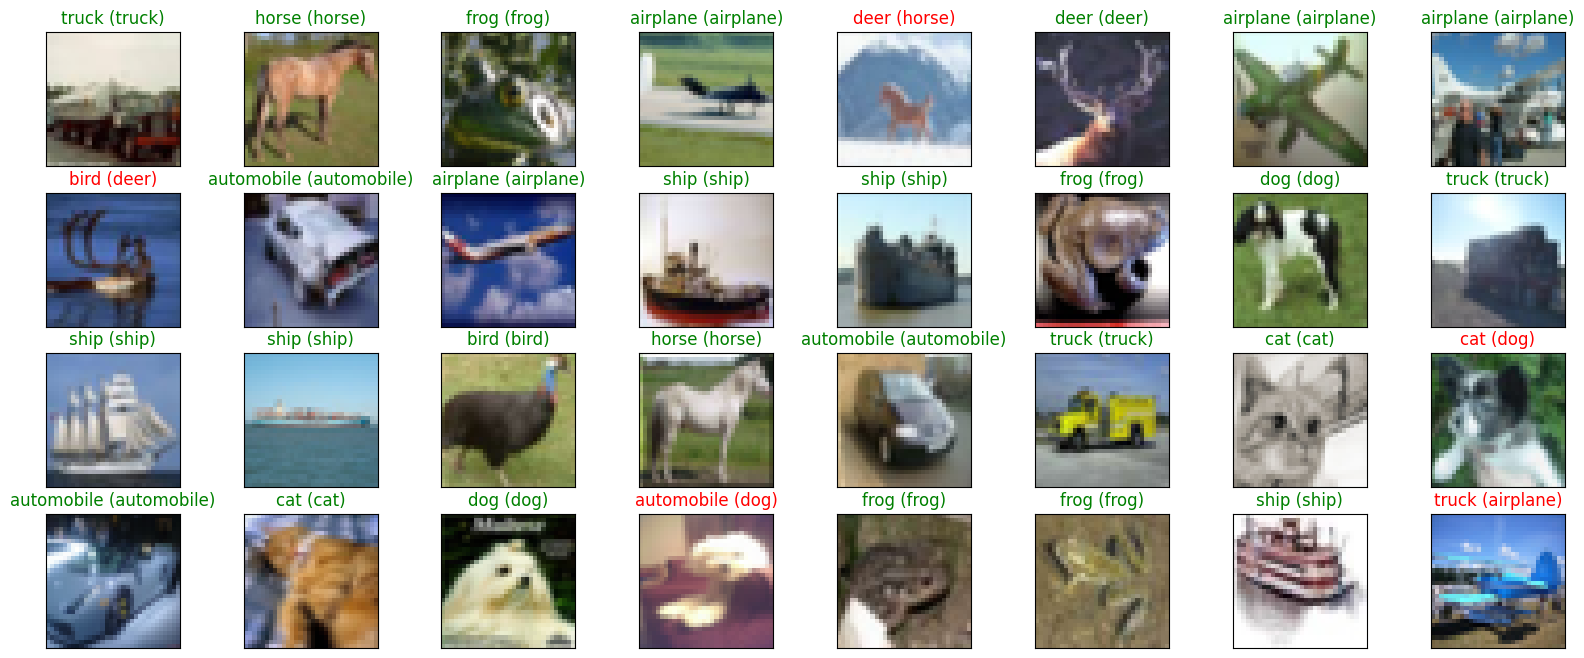

In [19]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))